## This file is for data processing. 

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [9]:
def read_data(fname):
    df = pd.read_excel('raw_data/' + fname, header = None)
    name=df.columns[0]
    df['string']=df[name].str.split()

    df['YYYY-Mon-Day']=df['string'].agg(lambda x:x[0])
    df['HH:MM']=df['string'].agg(lambda x:x[1])
    # df['Daylight']=df['string'].agg(lambda x:x[2])
    df['RA']=df['string'].agg(lambda x:str(x[-15]+x[-14]+x[-13]))
    df['DEC']=df['string'].agg(lambda x:str(x[-12]+x[-11]+x[-10]))
    df['dRA*cosD']=df['string'].agg(lambda x:x[-9])
    df['d(DEC)/dt']=df['string'].agg(lambda x:x[-8])
    df['APmag']=df['string'].agg(lambda x:x[-7])
    df['S-brt']=df['string'].agg(lambda x:x[-6])
    df['delta']=df['string'].agg(lambda x:x[-5])
    df['deldot']=df['string'].agg(lambda x:x[-4])
    df['S-O-T']=df['string'].agg(lambda x:x[-3])
    df['r_TL']=df['string'].agg(lambda x:x[-2][1])
    df['S-T-O']=df['string'].agg(lambda x:x[-1])
    return df[['YYYY-Mon-Day', 'RA', 'DEC']]

data = read_data('Berkeley.xlsx')
# data.to_csv (r'raw_data.csv',  index = False, header=True)
# data = pd.read_csv('raw_data.csv', usecols=['YYYY-Mon-Day', 'RA', 'DEC'])

In [ ]:
####################################
### Functions for Data Processing###
####################################

# This function unifies the unit of RA and DEC to be arc degrees. 
# Original units: RA  in hours-minutes-seconds of time,    HH MM SS.ff{ffff};
#                 DEC in degrees-minutes-seconds of arc,  sDD MN SC.f{ffff}.
# Inputs: s is a string, col specifies the column is "RA" or "DEC".
def change_unit(s, col): 
    num = float(s)
    hr = int(num/10000)
    min = int(num/100) - hr * 100
    sec = num - hr * 10000 - min * 100
    total_sec = hr * 3600 + min * 60 + sec
    if col == "RA":
        return total_sec * 15 / 3600 # 1 second of time = 15 seconds of arc
    return total_sec / 3600

# This function calculates the distance between lunar locations every 24 hours,
# which is also the daily average speed of lunar motion by definition.
#
# Inputs: the coordinates of observed moon locations (RA, DEC)
# Output: the straight line distance by Pythagoras (unit in arc seconds)
def parts(x, y):
    n = len(x)
    difx = np.zeros(n)
    dify = np.zeros(n)
    parts = np.zeros(n) 
    for i in range (n-1):
        difx[i] = (x[i+1] - x[i]) % 360
        dify[i] = y[i+1] - y[i]
        parts[i] = math.sqrt(difx[i]**2 + dify[i]**2)
        #parts[i] = difx #or only longtitude difference?
    return difx, dify, parts

# This function calcualtes the 'Rate' based on the input 'Parts' and also 
# calculates the Rate of lessening or increase. 
def rate(x):
    n=len(x)
    y=np.zeros(n)
    for i in range (n-1):
        y[i]=x[i+1]-x[i]
    return y

# This function calculates the cumulative RLI based on RLI 
# Input: RLI ---- Rate of lessening or increase 
# Output: CRLI ---- Cumulative Rate of lessening or increase 
def crli(rli):
    n = len(rli)
    y = np.zeros(n)
    for i in range(1, n):
        y[i] = y[i-1] + rli[i-1]
    return y

# This function employs all the helper functions above on the input dataframe 
# and outputs the new dataframe.
def data_process(data):
    data["RA"] = data["RA"].apply(lambda x: change_unit(x, "RA"))
    data["DEC"] = data["DEC"].apply(lambda x: change_unit(x, "DEC"))
    data['dRA'], data['dDEC'], data['Parts'] = parts(data['RA'], data["DEC"])
    data['Rate']=rate(data['Parts'])
    mean_pt=np.mean(data['Parts'])
    data['RLI']=data['Parts']-mean_pt
    data['CRLI'] = crli(data['RLI'])
    return data

In [ ]:
aa = data_process(read_data('Addis Ababa.xlsx')) # Addis Ababa
ad = data_process(read_data('Adelaide.xlsx')) # Adelaide
bj = data_process(read_data('Beijing.xlsx')) # Beijing
bk = data_process(read_data('Berkeley.xlsx')) # Berkeley
br = data_process(read_data('Brasilia.xlsx')) # Brasilia
ld = data_process(read_data('London.xlsx')) # London
aa.head()

,YYYY-Mon-Day,RA,DEC,dRA,dDEC,Parts,Rate,RLI,CRLI
0,2019-Oct-21,112.900542,22.821083,14.867208,-1.624000,14.955643,0.058638,1.226506,0.000000
1,2019-Oct-22,127.767750,21.197083,14.722250,-2.946861,15.014281,-0.026848,1.285144,1.226506
2,2019-Oct-23,142.490000,18.250222,14.415125,-4.102111,14.987433,-0.058359,1.258296,2.511651
3,2019-Oct-24,156.905125,14.148111,14.068000,-4.996861,14.929074,-0.060262,1.199937,3.769947
4,2019-Oct-25,170.973125,9.151250,13.788000,-5.565306,14.868812,-0.058076,1.139675,4.969884


In [ ]:
# Output processed data to csv file.
aa.to_csv (r'Addis Ababa.csv',  index = False, header=True)
ad.to_csv (r'Adelaide.csv',  index = False, header=True)
bj.to_csv (r'Beijing.csv',  index = False, header=True)
bk.to_csv (r'Berkeley.csv',  index = False, header=True)
br.to_csv (r'Brasilia.csv',  index = False, header=True)
ld.to_csv (r'London.csv',  index = False, header=True)

In [ ]:
# This function plots the daily change of *col_name* in the span of *span*.
# Inputs: col_name --- "RA", "DEC", "dRA", "dDEC", or "Parts"
#         span     --- "m" (two lunar months) or "y" (a solar year)
#         title    --- title of the plot
#         ylabel   --- ylabel of the plot
def draw(col_name, span, title, ylabel):
    if span == 'm':
        start, length, end = 19, 54, 73
    elif span == 'y':
        start, length, end = 0, 365, -1
    plt.plot(range(length), aa.iloc[start:end][col_name], 'g', label = "Addis Ababa")
    plt.plot(range(length), ad.iloc[start:end][col_name], 'b', label = "Adelaide")
    plt.plot(range(length), bj.iloc[start:end][col_name], 'r', label = "Beijing")
    plt.plot(range(length), bk.iloc[start:end][col_name], 'c', label = "Berkeley")
    plt.plot(range(length), br.iloc[start:end][col_name], 'y', label = "Brasilia")
    plt.plot(range(length), ld.iloc[start:end][col_name], 'm', label = "London")
    plt.title(title)
    plt.legend()
    plt.xlabel("Day of Sequence")
    plt.ylabel(ylabel)
    plt.show()

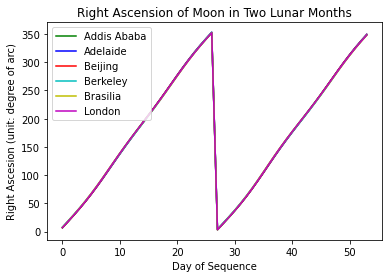

In [ ]:
draw('RA', 'm', "Right Ascension of Moon in Two Lunar Months", "Right Ascesion (unit: degree of arc)")

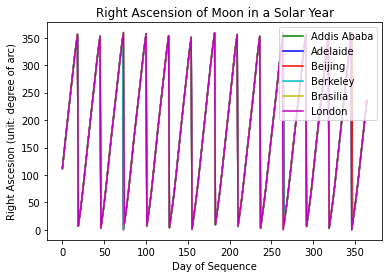

In [ ]:
draw('RA', 'y', "Right Ascension of Moon in a Solar Year", "Right Ascesion (unit: degree of arc)")

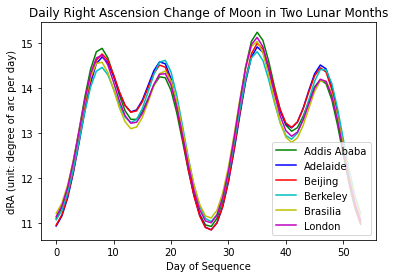

In [ ]:
draw('dRA', 'm', "Daily Right Ascension Change of Moon in Two Lunar Months", "dRA (unit: degree of arc per day)")

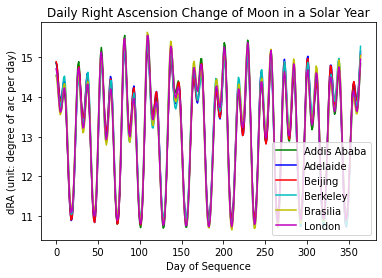

In [ ]:
draw('dRA', 'y', "Daily Right Ascension Change of Moon in a Solar Year", "dRA (unit: degree of arc per day)")

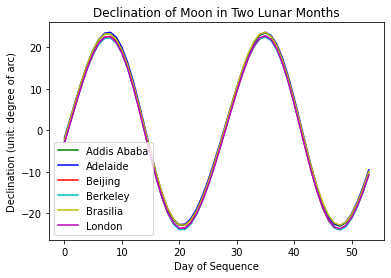

In [ ]:
draw('DEC', 'm', "Declination of Moon in Two Lunar Months", "Declination (unit: degree of arc)")

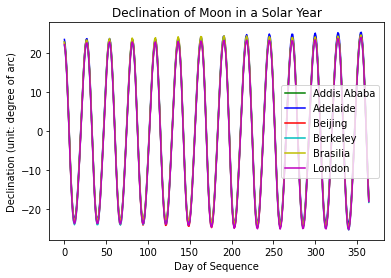

In [ ]:
draw('DEC', 'y', "Declination of Moon in a Solar Year", "Declination (unit: degree of arc)")

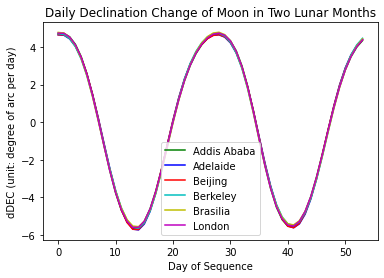

In [ ]:
draw('dDEC', 'm', "Daily Declination Change of Moon in Two Lunar Months", "dDEC (unit: degree of arc per day)")

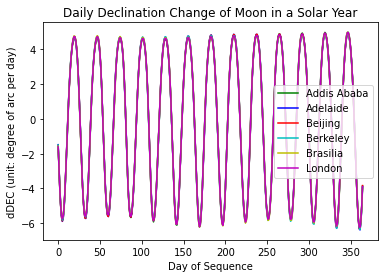

In [ ]:
draw('dDEC', 'y', "Daily Declination Change of Moon in a Solar Year", "dDEC (unit: degree of arc per day)")

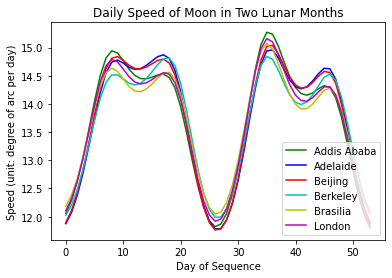

In [ ]:
draw('Parts', 'm', "Daily Speed of Moon in Two Lunar Months", "Speed (unit: degree of arc per day)")

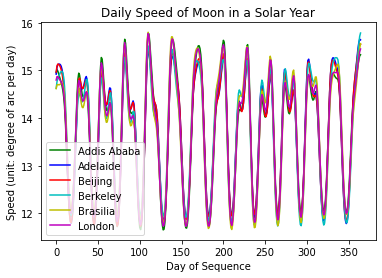

In [ ]:
draw('Parts', 'y', "Daily Speed of Moon in a Solar Year", "Speed (unit: degree of arc per day)")